# sanity check

### fit gaussian to psfs and check FWHM

In [1]:
import numpy                as np
from   astropy.table        import Table
from   astropy.io           import fits
from   scipy.optimize       import curve_fit
from    tqdm                import tqdm
import matplotlib.pyplot    as plt
from   mpl_toolkits.mplot3d import Axes3D
from   astropy.io           import fits
import matplotlib.colors    as colors

# define a handy funcdtion to find the image data by name
def find_data(name,hdu):
    for i,image in enumerate(hdu):
        if name == image.name:
            return i,image

# define a handy function to get the data product name
def file_name(obj,prefix,filetype='fits'):
    field = obj['subfield'].lower()
    return f"hlsp_clear_hst_wfc3_{field}-{obj['id']}_g102-g141_v4_{prefix}.{filetype}"



### gen psf matching kernel, initial check

In [2]:
from    photutils.psf       import matching as match
from    astropy.convolution import convolve_fft 
from    IPython.display     import clear_output

#generate matching kernel for psf_ha & psf_hb
def gen_kernel(psf_hb,psf_ha):
        window = match.CosineBellWindow(alpha=1.25)
        kernel = fits.ImageHDU(
                data = match.create_matching_kernel(psf_hb.data,psf_ha.data,window=window),
                name = 'PSF_MATCH')
        kernel.data = kernel.data/np.sum(kernel.data)
        return kernel 

def match_psf(obj):
    print(obj)
    #path for extracted hdu list and combined psf
    path_to_psf = f"psf/combined_psf/{obj['subfield']}_{obj['id']}"

    #open and update extracted file, add psf_kernel
    psf_ha = fits.open(f'{path_to_psf}_ha.fits')[1]
    psf_hb = fits.open(f'{path_to_psf}_hb.fits')[1]
    kernel = gen_kernel(psf_hb,psf_ha)

    kernel.writeto(f"psf/matching_kernel/{obj['subfield']}_{obj['id']}.fits",overwrite=True)
    clear_output(wait=True)
    return f"{obj['subfield']}_{obj['id']} processed"


from concurrent.futures     import ThreadPoolExecutor, as_completed
def cat_process_match_psf(obj_lis,max_threads=1):
    results = []
    if max_threads>1:
        with ThreadPoolExecutor(max_threads) as executor:
            futures = {executor.submit(match_psf,obj):obj for obj in obj_lis}
            for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                results.append(future.result())
        return results
    else:
        for obj in tqdm(obj_lis):
            results.append(match_psf(obj))
        return results

if __name__ == '__main__':
    obj_lis = Table.read('obj_lis_selected.fits')
    results = cat_process_match_psf(obj_lis,max_threads=7)
    number = 0
    for result in results:
        if 'error' in result:
            number +=1
            print(result)
    print('total number of obj processed:',len(results))
    print('number of failed obj',number)

Processing: 100%|██████████| 158/158 [00:03<00:00, 50.72it/s]

total number of obj processed: 158
number of failed obj 0


In [3]:
# Define the 2D Gaussian function for data fitting
def gaussian_2d(x, y, amplitude, fwhm, x0, y0, c):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amplitude * np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) + c

# Fit the 2D Gaussian function to a imagehdu
def fit_gaussian_2d(image):
    size_x, size_y = image.shape

    x = np.linspace(0, size_x - 1, size_x)
    y = np.linspace(0, size_y - 1, size_y)
    x, y = np.meshgrid(x, y)
    initial_guess = (np.max(image.data), 2, 24.5, 24.5,0.01)
    popt, pcov = curve_fit(
        lambda xy, amplitude, fwhm, x0, y0, c: gaussian_2d(xy[0], xy[1], amplitude, fwhm, x0, y0, c), (x.ravel(), y.ravel()), image.data.ravel(), p0=initial_guess)
    return popt

# compute fwhm for psfs and kernels of one object and compare
def psf_check(obj):
    #load psf images and fit 2d gaussian
    with fits.open(f"psf/combined_psf/{obj['subfield']}_{obj['id']}_ha.fits") as hdu:
        popt_ha = fit_gaussian_2d(hdu[1])
    with fits.open(f"psf/combined_psf/{obj['subfield']}_{obj['id']}_hb.fits") as hdu:
        popt_hb = fit_gaussian_2d(hdu[1])
    #load matching kernel and also fit 2d gaussian
    kernel = fits.open(f"psf/matching_kernel/{obj['subfield']}_{obj['id']}.fits")[1]
    popt_kernel = fit_gaussian_2d(kernel)
    return [obj['subfield'],obj['id'],*popt_ha, *popt_hb,*popt_kernel]

#cat process, gen fit results table
def cat_process():
    col_names = ['subfield','id','amplitude_ha', 'fwhm_ha', 'x0_ha', 'y0_ha', 'c_ha', 'amplitude_hb', 'fwhm_hb', 'x0_hb', 'y0_hb', 'c_hb', 'amplitude_kernel', 'fwhm_kernel', 'x0_kernel', 'y0_kernel', 'c_kernel']
    obj_lis = Table.read('obj_lis_selected.fits')
    rows = []
    for obj in tqdm(obj_lis):
        rows.append(psf_check(obj))
    Table(rows=rows,names=col_names).write('psf/psf_fitresults.fits',overwrite=True)
    return 'cat_processed'
if __name__ == '__main__':
    cat_process()

100%|██████████| 158/158 [00:02<00:00, 70.19it/s]


### check fwhm 

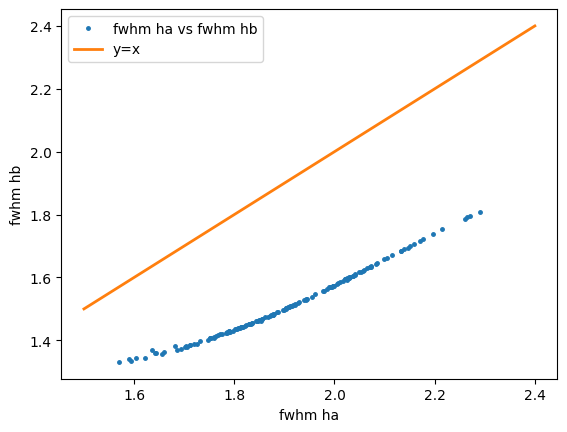

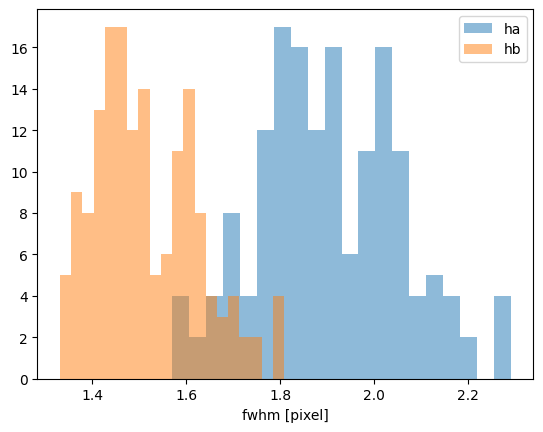

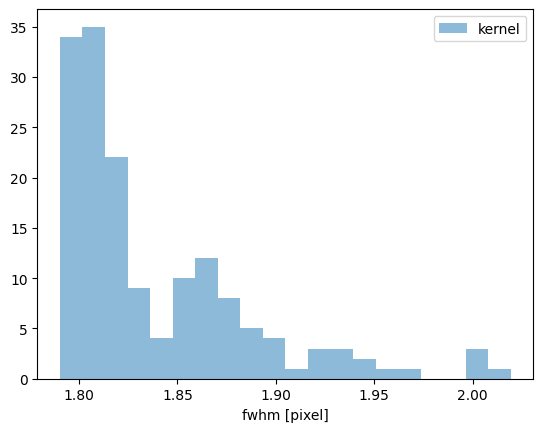

In [3]:
psf_results = Table.read('psf/psf_fitresults.fits')
fwhm_diff = psf_results['fwhm_ha'] - psf_results['fwhm_hb']

plt.plot(psf_results['fwhm_ha'],psf_results['fwhm_hb'],linewidth=0,marker='o',markersize=2.5,label='fwhm ha vs fwhm hb')
plt.plot([1.5,2.4],[1.5,2.4],linewidth=2,label='y=x')
plt.xlabel('fwhm ha');plt.ylabel('fwhm hb')
plt.legend();plt.show()


plt.hist(psf_results['fwhm_ha'],bins=20,label='ha',alpha=0.5)
plt.hist(psf_results['fwhm_hb'],bins=20,label='hb',alpha=0.5)
plt.xlabel('fwhm [pixel]');plt.legend()
plt.show()

plt.hist(psf_results['fwhm_kernel'],bins=20,label='kernel',alpha=0.5)
plt.xlabel('fwhm [pixel]');plt.legend()
plt.show()



[2.06563973e-01 1.61935467e+00 2.49941157e+01 2.50121339e+01
 1.51873118e-04]


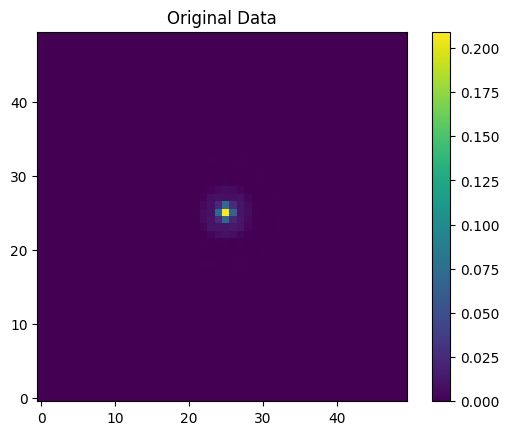

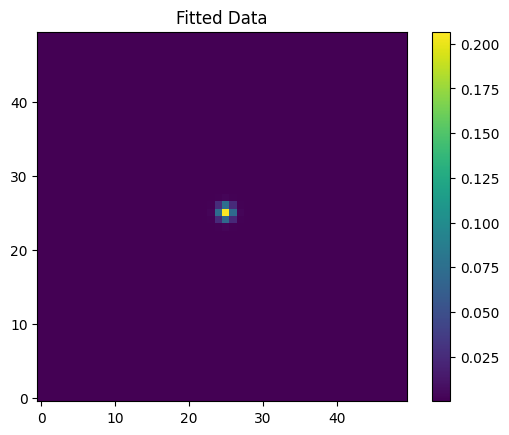

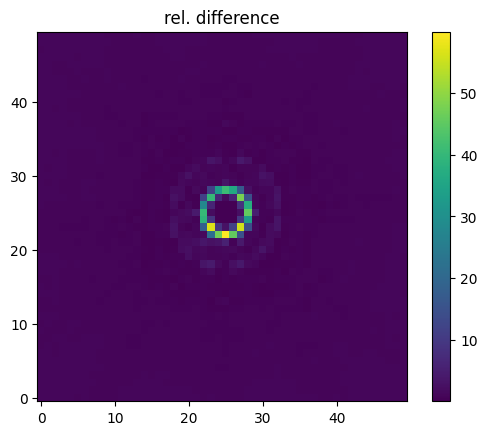

In [10]:
%matplotlib inline
with fits.open('psf/combined_psf/ERSPRIME_38832_hb.fits') as hdu:
        image_data = hdu[1].data
        popt = fit_gaussian_2d(hdu[1])
        print(popt)

        # Plot original data
        plt.figure()
        plt.imshow(image_data, origin='lower', cmap='viridis')
        plt.colorbar()
        plt.title('Original Data')

        # Generate fitted data
        size_x, size_y = image_data.shape
        x = np.linspace(0, size_x - 1, size_x)
        y = np.linspace(0, size_y - 1, size_y)
        x, y = np.meshgrid(x, y)
        fitted_data = gaussian_2d(x, y, *popt)

        # Plot fitted data
        plt.figure()
        plt.imshow(fitted_data, origin='lower', cmap='viridis')
        plt.colorbar()
        plt.title('Fitted Data')
        plt.show()

        plt.imshow(np.abs(fitted_data - image_data)/fitted_data, 
                #norm = colors.LogNorm(),
                origin='lower', cmap='viridis')
        plt.colorbar()
        plt.title('rel. difference')